<a href="https://colab.research.google.com/github/Mykolays/ML/blob/main/Neural_nets_and_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural nets and ensembles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "/content/drive/MyDrive/ML/OnlineNewsPopularityReduced.csv"
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            4954 non-null   object 
 1   timedelta                      4954 non-null   int64  
 2   n_tokens_title                 4954 non-null   int64  
 3   n_tokens_content               4954 non-null   int64  
 4   n_unique_tokens                4954 non-null   float64
 5   n_non_stop_words               4954 non-null   float64
 6   n_non_stop_unique_tokens       4954 non-null   float64
 7   num_hrefs                      4954 non-null   int64  
 8   num_self_hrefs                 4954 non-null   int64  
 9   num_imgs                       4954 non-null   int64  
 10  num_videos                     4954 non-null   int64  
 11  average_token_length           4954 non-null   float64
 12  num_keywords                   4954 non-null   i

Deletes unnecessary columns and those records where 0 words

In [3]:
df.drop(labels=['url', 'timedelta'], axis = 1, inplace=True)
df = df[df.n_tokens_content != 0]

In [4]:
df.kw_min_min.value_counts()

-1    4466
Name: kw_min_min, dtype: int64

We have an uninformative column, we delete should it

In [5]:
df.drop('kw_min_min', axis = 1, inplace = True)

The distribution of our target variable looks like this:

<Axes: xlabel='shares', ylabel='Density'>

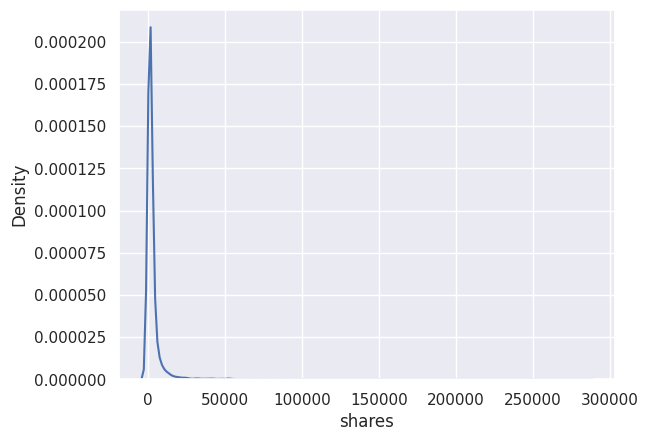

In [6]:
sns.kdeplot(df, x='shares')

<Axes: xlabel='shares', ylabel='Density'>

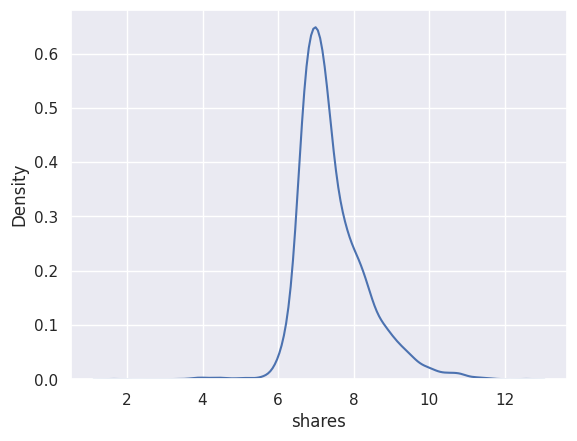

In [7]:
sns.kdeplot(np.log(df['shares']))


As we can see, our distribution is lognormal

<Axes: >

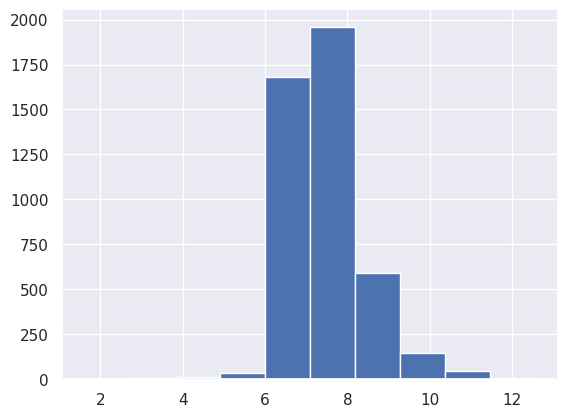

In [8]:
df['shares'] = np.log(df.shares)
df.shares.hist()

## Load and prepare data

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


X = df.drop('shares', axis=1)
y = df['shares']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=4)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

## Buil model

In [10]:
mlpr = MLPRegressor((30,30))
mlpr.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(30, 30))

In [11]:
y_pred = mlpr.predict(X_valid)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 1.0060930845720764
R2: -0.3315617310802652


Very bad r2-score. This indicator must be positive. Let's find best hyperparameters

In [12]:
hidden = [(100,), (100, 50), (100, 50, 20), (50, 50), (50, 50, 50), (50, 30, 30, 20)]
param_grid = {'alpha': np.logspace(-5, 2, 10),\
                    'hidden_layer_sizes': hidden,\
                    'activation': ['relu', 'tanh', 'logistic'],\
                    'learning_rate_init': [0.0001, 0.001,0.01,0.1]
              }
model_grid = RandomizedSearchCV(mlpr, param_grid, cv=5, scoring='r2',  n_jobs=-1, random_state=4)
model_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=MLPRegressor(hidden_layer_sizes=(30, 30)),
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': array([1.00000000e-05, 5.99484250e-05, 3.59381366e-04, 2.15443469e-03,
       1.29154967e-02, 7.74263683e-02, 4.64158883e-01, 2.78255940e+00,
       1.66810054e+01, 1.00000000e+02]),
                                        'hidden_layer_sizes': [(100,),
                                                               (100, 50),
                                                               (100, 50, 20),
                                                               (50, 50),
                                                               (50, 50, 50),
                                                               (50, 30, 30,
                                                                20)],
                                        'learning_rate_init': [0.0001, 0.001,
                                                               0.01, 0.1]},
                   random_state=4, scoring='r2')

In [13]:
print("Best Parameters:", model_grid.best_params_)
print("Best R^2 Score:", model_grid.best_score_)

Best Parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.00035938136638046257, 'activation': 'logistic'}
Best R^2 Score: 0.13178436859119733


In [14]:
y_pred = model_grid.best_estimator_.predict(X_valid)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.6490261499833766
R2: 0.14101548152892385


The best result for all previous models, but low performance. Maybe it`s impossible gain r2_score more than 0.5 for this set of dates. Lets plot validation curve

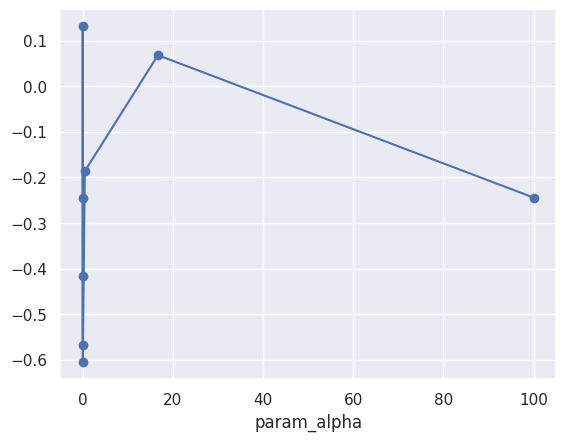

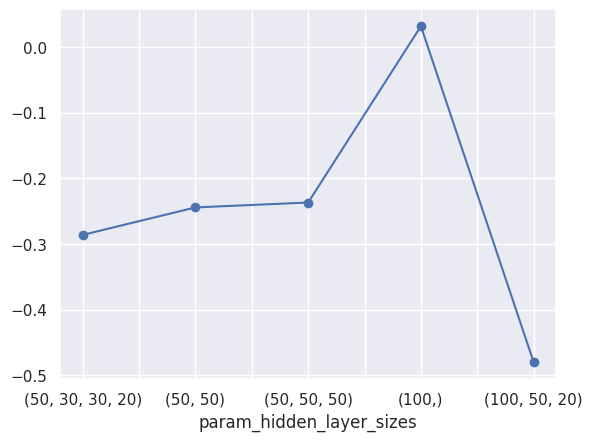

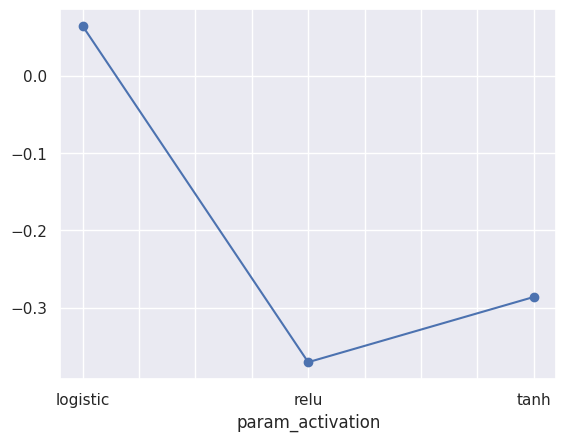

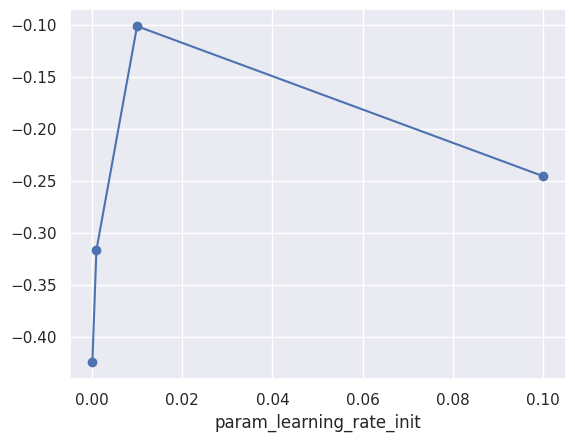

In [15]:
result = pd.DataFrame(model_grid.cv_results_)
for feature in ['param_alpha','param_hidden_layer_sizes','param_activation','param_learning_rate_init']:
  result.groupby(feature)['mean_test_score'].mean().plot(marker='o')
  plt.show()

As we can see, our r2_score is close to negative for all parameters

## Build BaggingRegressor

In [16]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

bagging = BaggingRegressor(Ridge(),max_samples=0.5)

bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_valid)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.6642351299609892
R2: 0.1208864338120631


In [17]:
param = {'n_estimators': np.arange(10, 201, 20)}

bagging_grid = GridSearchCV(bagging, param,cv=5, scoring="r2",n_jobs=-1)
bagging_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(estimator=Ridge(), max_samples=0.5),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190])},
             scoring='r2')

In [18]:
print(bagging_grid.best_score_)
print(bagging_grid.best_params_)

0.11538817325986235
{'n_estimators': 30}


In [19]:
from sklearn.model_selection import validation_curve
def plot_validation_curve(estimator, X, y, param_name, param_range, scoring='r2', cv=5, log_scale=True):
    # Get training and validation scores
    train_scores, valid_scores = validation_curve(
        estimator, X, y,
        param_name=param_name, param_range=param_range,
        scoring=scoring, cv=cv
    )

    # Calculate mean and standard deviation for training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, label='Training score', color='blue', marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    plt.plot(param_range, valid_mean, label='Cross-validation score', color='red', marker='o')
    plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='red')

    plt.title(f'Validation Curve for {param_name} in {estimator.__class__.__name__}')
    plt.xlabel(param_name)
    plt.ylabel(f'{scoring.capitalize()} Score')

    if log_scale:
        plt.xscale('log')  # Log scale for better visualization if the parameter varies widely

    plt.legend()
    plt.show()

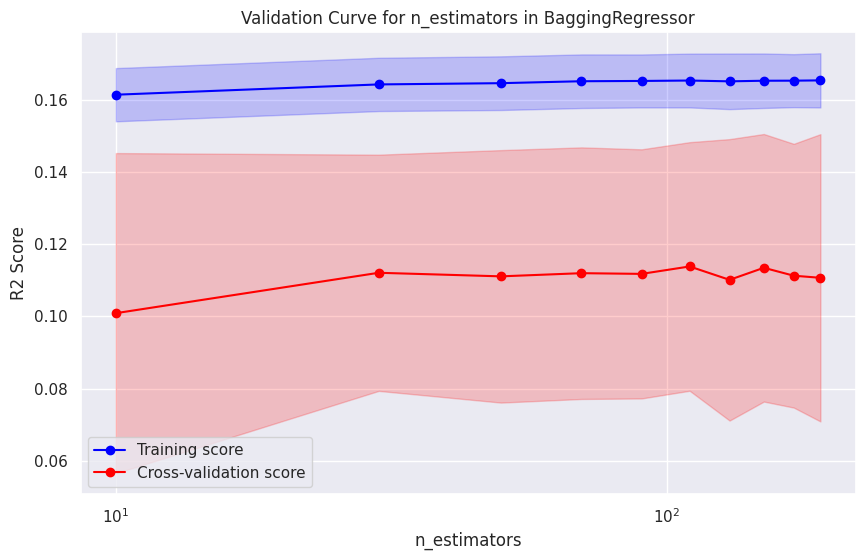

In [20]:
plot_validation_curve(bagging_grid.best_estimator_, X_train, y_train, 'n_estimators', np.arange(10, 201, 20))

In [21]:
y_pred = bagging_grid.best_estimator_.predict(X_valid)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.6615225833523442
R2: 0.12447648259902966


Have good r2 score for this dataset, but MLPRegressor shows better resault.

Build BoostRegressor

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

grbr = GradientBoostingRegressor(random_state=4)
grbr.fit(X_train, y_train)
y_pred = grbr.predict(X_valid)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.6321691298581139
R2: 0.1633257063411705


From the start we received the best score for all models. Lets find best parameters

In [23]:
param = {'n_estimators': np.arange(2, 101, 5)}


boost_grid = GridSearchCV(grbr, param,cv=5, scoring="r2",n_jobs=-1)
boost_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=4),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82,
       87, 92, 97])},
             scoring='r2')

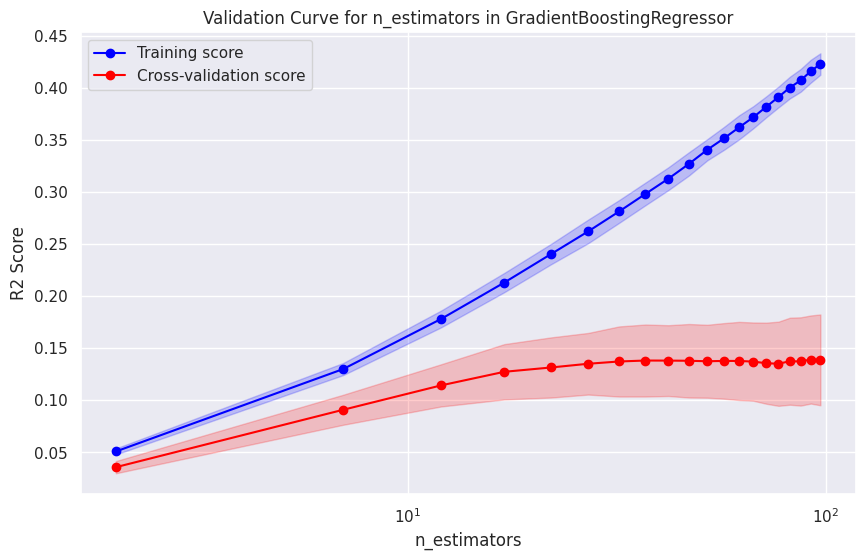

In [24]:
plot_validation_curve(boost_grid.best_estimator_, X_train, y_train, 'n_estimators', np.arange(2, 101, 5))

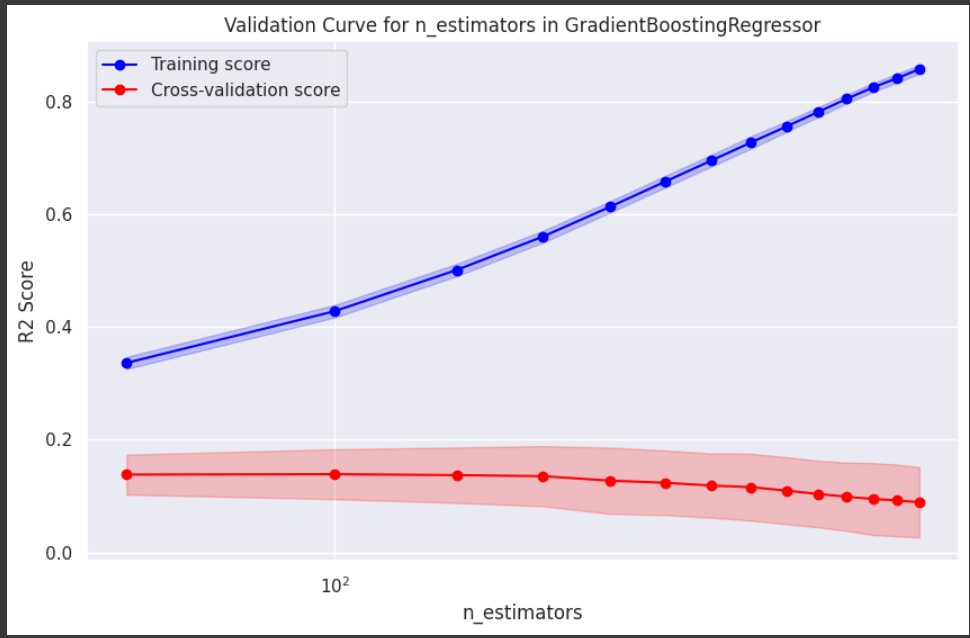

In [25]:
print("Best Parameters:", boost_grid.best_params_)
print("Best R^2 Score:", boost_grid.best_score_)

Best Parameters: {'n_estimators': 92}
Best R^2 Score: 0.13929611833963668


In [26]:
y_pred = boost_grid.best_estimator_.predict(X_valid)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.6308267178903052
R2: 0.16510238528975751


## Conclusion

R2_score on each model:
* knn -- 0.04865
* DesicionTree -- 0.05048
* RandomForest -- 0.128019
* LinearRegressor -- 0.09266
* MLPRegressor -- 0.141
* BaggingRegressor -- 0.12447
* GradientBoostingRegressor -- 0.16510

As we can see, best model for this dataset is GradientBoostingRegressor from all considered models